In [2]:
import os
import torch
import torchaudio
import numpy as np
import datasets
from evaluate import load
from dataclasses import dataclass
from typing import Dict, List, Union, Optional
from datasets import load_dataset, load_from_disk
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor, TrainingArguments, Trainer

In [ ]:
DATASET_PATH = "../data/common_voice"
MODEL_CHECKPOINT = "facebook/wav2vec2-large-960h"

## Prepare Dataset

We load the `cv-valid-train.csv` and do a 70-30 split according to the requirements.

In [3]:
dataset = load_dataset(
    'csv', 
    data_files = os.path.join(
        DATASET_PATH, 
        'cv-valid-train.csv'
    ), 
    split='train'
)

splits = dataset.train_test_split(test_size=0.3, seed=42)

train_dataset, test_dataset = splits['train'], splits['test']

## Exploratory Data Analysis

Let's start by taking a look at the labels.

In [4]:
train_dataset[0]

{'filename': 'cv-valid-train/sample-018873.mp3',
 'text': "it seemed as if what the old king had called beginner's luck were no longer functioning",
 'up_votes': 3,
 'down_votes': 0,
 'age': 'fifties',
 'gender': 'female',
 'accent': 'england',
 'duration': None}

It looks like the 'text' column contains the ground truth transcription, which appears to be in all lowercase. Let's check if all the labels in the dataset are consistently lowercase.

In [ ]:
all_chars = set()
for txt in dataset['text']:
    all_chars.update(txt) 

# Convert to a sorted list for readability
unique_chars = sorted(all_chars)
print(unique_chars)
print(f"Total unique characters: {len(unique_chars)}")


[' ', "'", 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Total unique characters: 28


We can see that the labels in the Common Voice datset consists of the a-z alphabets in lowercase, along with a space " " and an apostrophe "'" character.

Next, we need to check if the Wav2Vec2 tokenizer uses the same set of characters as our dataset.

In [6]:
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained(MODEL_CHECKPOINT)
print(f"Wav2Vec2CTCTokenizer Vocab: {sorted(list(tokenizer.get_vocab().keys()))}")

Wav2Vec2CTCTokenizer Vocab: ["'", '</s>', '<pad>', '<s>', '<unk>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '|']


*THIS IS A PROBLEM* - our dataset labels consist of lowecase alphabets, while the tokenizer's vocab consist of uppercase alphabets -> We need to convert the labels to upper case during preprocessing.

Let's confirm our hypothesis.

In [7]:
print(tokenizer.decode(tokenizer.encode("HTX")))

print(tokenizer.decode(tokenizer.encode("htx")))

HTX
<unk>


As expected, the Wav2Vec2 Tokenizer treats lowercase alphabet characters as unknown tokens and maps them to the `<unk>` token.

## Preprocessing

Next, let's preprocess the dataset. We need to do a few things:

* Load the audio files using TorchAudio
* Resample to 16kHz if necessary
* Convert to mono if necessary
* Extract features from the waveform using the Wav2Vec2Processor
* Convert the labels to uppercase
* Tokenize the labels using the Wav2Vec2Processor

We can use the `.map()` method to apply these transformations to the dataset.

In [ ]:
processor = Wav2Vec2Processor.from_pretrained(MODEL_CHECKPOINT)

def prepare_dataset(batch):
    # Load audio file
    audio_base_path = os.path.join(DATASET_PATH, "cv-valid-train")
    audio_path = os.path.join(audio_base_path, batch["filename"])
    waveform, sampling_rate = torchaudio.load(audio_path)

    # Convert to mono if stereo
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    # Resample to 16kHz if needed
    if sampling_rate != 16000:
        resampler = torchaudio.transforms.Resample(sampling_rate, 16000)
        waveform = resampler(waveform)

    # Extract features
    batch["input_values"] = processor(
        waveform.squeeze().numpy(),
        sampling_rate=16000
    ).input_values[0]

    # Get length of input for excluding long samples later
    batch["input_len"] = len(batch["input_values"])
    
    # Tokenize the uppercase text labels
    text = batch["text"].upper()
    batch["labels"] = processor.tokenizer(text).input_ids
    return batch

# Check if preprocessed data exists
if os.path.exists("./preprocessed_data/truncated/train"):

    print("Loading preprocessed data...")
    train_dataset = load_from_disk("./preprocessed_data/truncated/train")
    test_dataset = load_from_disk("./preprocessed_data/truncated/test")

else: # Apply preprocessing

    print("Preprocessing data...")
    
    train_dataset = train_dataset.map(
        prepare_dataset,
        remove_columns=train_dataset.column_names,
        num_proc=16
      )

    test_dataset = test_dataset.map(
        prepare_dataset,
        remove_columns=test_dataset.column_names,
        num_proc=16
    )

    # Save the preprocessed data to disk
    train_dataset.save_to_disk("./preprocessed_data/truncated/train")
    test_dataset.save_to_disk("./preprocessed_data/truncated/test")

Loading preprocessed data...


Loading dataset from disk:   0%|          | 0/79 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/34 [00:00<?, ?it/s]

Next, due to GPU memory constraints, I had to remove any samples that are more than 5 seconds long. Initially, when I trained with the full dataset, the training process would crash due to out-of-memory errors, even with an 80GB A100. Therefore, I have to remove any samples that are more than 5 seconds long.

In [10]:
print(f"Length of train dataset before removing long audio: {len(train_dataset)}")
print(f"Length of test dataset before removing long audio: {len(test_dataset)}")

Length of train dataset before removing long audio: 137043
Length of test dataset before removing long audio: 58733


In [ ]:
max_len = 5 * 16000 # 5 seconds, 16000 is the sampling rate

train_dataset = train_dataset.filter(lambda x: x < max_len, input_columns=["input_len"])
test_dataset = test_dataset.filter(lambda x: x < max_len, input_columns=["input_len"])

In [12]:
print(f"Length of train dataset after removing long audio: {len(train_dataset)}")
print(f"Length of test dataset after removing long audio: {len(test_dataset)}")

Length of train dataset after removing long audio: 93598
Length of test dataset after removing long audio: 40049


As we can see, its not ideal as we are losing quite a bit of training data, but unfortunately we have to do this due to GPU memory constraints.

## Data Collator

Next, we need a DataCollator class to handle batched training inputs to the model. The data collator needs to pad the input sequences to the length of the longest audio in the batch using the Wav2Vec2Processor. It also needs to create an attention mask so that the model ignores the padded positions during training. We will use -100 as the padding value because PyTorch's CTC loss function ignores -100 labels.

We will use the DataCollatorCTCWithPadding class from the transformers repository (link below).

https://github.com/huggingface/transformers/blob/9a06b6b11bdfc42eea08fa91d0c737d1863c99e3/examples/research_projects/wav2vec2/run_asr.py#L81

In [ ]:
@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [ ]:
data_collator = DataCollatorCTCWithPadding(
    processor=processor, 
    padding=True
)

## Evaluation Metric

Next, we also need an evaluation metric to measure the performance of our ASR model, in addition to the CTC loss. We will use the Word Error Rate (WER) metric, which measures the percentage of words that are incorrect in the transcription. WER is a common metric used in ASR tasks.

Again, we will use the `compute_metrics` function from the transformers repository to calculate the WER metric.

https://github.com/huggingface/transformers/blob/9a06b6b11bdfc42eea08fa91d0c737d1863c99e3/examples/research_projects/wav2vec2/run_asr.py#L250

In [ ]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer_metric = load("wer")
    wer_score = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer_score}

## Training

### Debugging Steps

Note: Initially, I faced an issue of the model consistently returning 0 training loss at each step - with 0 loss, the model does not learn and performs poorly on the validation set. 

The following cells contain my debugging steps, and how I eventually fixed the issue.

The issue arises when loading the model from the `facebook/wav2vec2-large-960h` checkpoint:

In [9]:
model = Wav2Vec2ForCTC.from_pretrained('facebook/wav2vec2-large-960h')

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We see the following warning:

`Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.`

Let's do a check to see if there are any NaNs in the weights.

In [10]:
for name, param in model.named_parameters():
    if torch.isnan(param).any():
        print(f"   NaN found in: {name}")

   NaN found in: wav2vec2.masked_spec_embed


This is a problem as `wav2vec2.masked_spec_embed` is NaN, which will result in NaN outputs during the forward pass.

Doing a google search on this issue shows that the issue is unresolved:

* https://github.com/pytorch/pytorch/issues/93464
* https://github.com/huggingface/transformers/issues/33995
* https://discuss.huggingface.co/t/some-weights-of-wav2vec2forctc-were-not-initialized-from-the-model-checkpoint-at-facebook-wav2vec2-base-960h-and-are-newly-initialized/25184

Checking the original paper (https://arxiv.org/pdf/2006.11477), it seems that this is related to the masking process during the self-supervised training phase: 

> We mask a proportion of the feature encoder outputs, or time steps before feeding them to the context
network and replace them with a trained feature vector shared between all masked time steps

It appears that masking is not strictly necessary for finetuning, and fortunately, the `Wav2Vec2ForCTC` class provides a way to disable it by setting `mask_time_prob` to 0.

https://huggingface.co/docs/transformers/en/model_doc/wav2vec2#transformers.Wav2Vec2Config.mask_time_prob

## Rest of Training

We'll initialize our model and set `mask_time_prob` to 0 as mentioned above. We will also freeze the feature extractor as we do not need to retrain them for finetuning tasks.

In [19]:
model = Wav2Vec2ForCTC.from_pretrained(
    MODEL_CHECKPOINT,
    ctc_loss_reduction="mean",
    mask_time_prob=0.0,  # Disable masked_spec_embed
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer)
)

# Freeze feature extractor
model.freeze_feature_extractor()

print(f"Model loaded: {MODEL_CHECKPOINT}")

Model loaded: facebook/wav2vec2-large-960h


/usr/local/lib/python3.12/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1818: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5. Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(


Due to time constraints, I could not experiment with different training hyperparameters such as learning rates or strategies to prevent overfitting. Instead, I will train the model for 3 epochs and use the validation loss and WER as a guide to see if we are overfitting the model.

As I'm using a 80GB A100 (from RunPod.io), we can increase the batch size to 512. 

We'll keep the eval steps to 100 to avoid evaluating too frequently which is computationally expensive. 

It takes around 4 hours to train the model for 3 epochs, including the time taken for validation.

In [ ]:
training_args = TrainingArguments(
    output_dir="./wav2vec2-finetuned-common-voice",
    group_by_length=False,
    per_device_train_batch_size=512,
    per_device_eval_batch_size=512,
    eval_strategy="steps",
    num_train_epochs=3,
    fp16=True,
    gradient_checkpointing=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=100,
    learning_rate=3e-4,
    warmup_steps=50,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
)

In [ ]:
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=processor.feature_extractor,
)

/tmp/ipykernel_13775/3539139704.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [25]:
print("Starting training...")
print(f"Training samples: {len(train_dataset)}")
print(f"Evaluation samples: {len(test_dataset)}")
print(f"Training epochs: {training_args.num_train_epochs}")

# Start training
trainer.train()

Starting training...
Training samples: 93598
Evaluation samples: 40049
Training epochs: 3


/usr/local/lib/python3.12/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:180: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss,Validation Loss,Wer
100,0.311100,0.223965,0.099315
200,0.281000,0.198762,0.089941
300,0.206000,0.153783,0.071368
400,0.165300,0.130851,0.062274
500,0.133400,0.113417,0.053547


/usr/local/lib/python3.12/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:180: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:180: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs

TrainOutput(global_step=549, training_loss=0.2093492014594851, metrics={'train_runtime': 11616.5878, 'train_samples_per_second': 24.172, 'train_steps_per_second': 0.047, 'total_flos': 4.241380003405539e+19, 'train_loss': 0.2093492014594851, 'epoch': 3.0})

Next, let's visualize the training and validation loss.

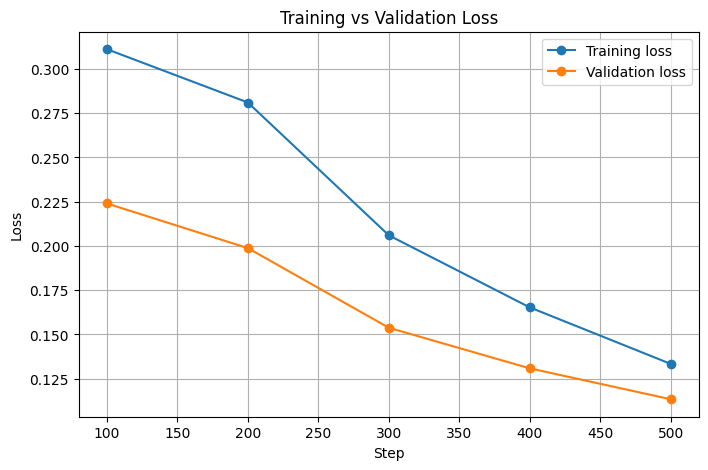

In [59]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history

train_loss = []
eval_loss = []
eval_wer = []
steps = []

for entry in logs:
    if "loss" in entry and "learning_rate" in entry:
        train_loss.append(entry["loss"])
        steps.append(entry["step"])
    else:
        if "eval_loss" in entry:
            eval_loss.append(entry["eval_loss"])
        if "eval_wer" in entry:
            eval_wer.append(entry["eval_wer"])

eval_steps = [entry["step"] for entry in logs if "eval_loss" in entry]

plt.figure(figsize=(8,5))
plt.plot(steps, train_loss, label="Training loss", marker='o')
plt.plot(eval_steps, eval_loss, label="Validation loss", marker='o')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

As we can see from the chart above, both the training and validation loss monotonically decreases with the number of steps. Evidently, the model has not overfitted to the training data as thge validation loss has not plateaued and in fact, it might be slightly underfitted. We can probably increase the number of training steps to further improve the performance of the model.

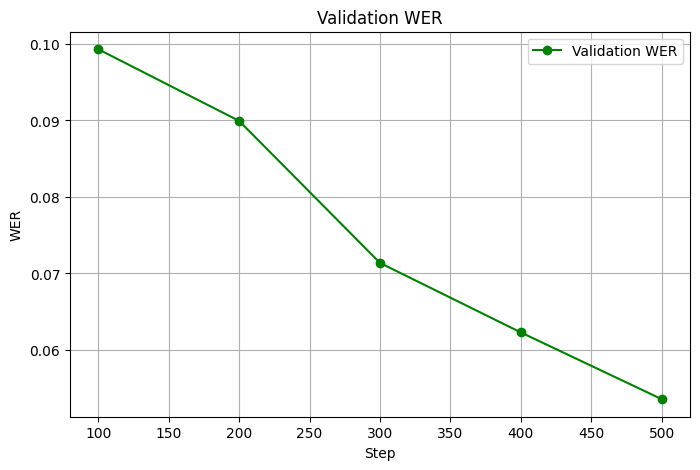

In [63]:
plt.figure(figsize=(8,5))
plt.plot(steps, eval_wer, label="Validation WER", marker='o', color='green')
plt.xlabel("Step")
plt.ylabel("WER")
plt.title("Validation WER")
plt.legend()
plt.grid(True)
plt.show()

Similarly, the validation WER continues to decrease with the number of steps and it has not plateaued. We will choose the model at the last checkpoint as the best model.

Next, let's save the model as `wav2vec2-large-960h-cv` according to the requirements.

In [31]:
final_model_path = 'wav2vec2-large-960h-cv'

model.save_pretrained(final_model_path)

## Evaluate on cv-valid-test

In [41]:
import pandas as pd
from tqdm.notebook import tqdm

In [ ]:
df_valid_test = pd.read_csv(os.path.join(DATASET_PATH, 'cv-valid-test.csv'))

predictions = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

for filename in tqdm(df_valid_test['filename']):
    filepath = os.path.join(DATASET_PATH, 'cv-valid-test', filename)
    waveform, sample_rate = torchaudio.load(filepath)

    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)
        sample_rate = 16000

    # Convert to 1D mono waveform from stereo if necessary
    # torchaudio returns shape [channels, time]
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0)  # convert to mono
    else:
        waveform = waveform.squeeze(0)

    # Extract features
    inputs = processor(waveform, sampling_rate=16000, return_tensors="pt", padding=True)

    # Move inputs to GPU
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = model(**inputs).logits

    # Decode prediction to text
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)[0]
    transcription = ''.join(transcription)

    predictions.append(transcription)

  0%|          | 0/3995 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

In [43]:
predictions[:5]

['WITHOUT A DATISET THE ARTICLE AS USELESS',
 "I'VE GOT TO GO TO HIM",
 'AND YOU KNOW IT',
 'DOWN BELOW IN THE DARKNESS WERE HUNDREDS OF PEOPLE SLEEPING IN PEACE',
 'HOLD YOUR NOSE TO KEEP THE SMELL FROM DISABLING YOUR MOTOR FUNCTIONS']

In [64]:
wer_metric = load("wer")

actual_transcriptions = list(df_valid_test['text'].values)

wer_score = wer_metric.compute(
    predictions=[p.lower() for p in predictions], 
    references=actual_transcriptions)

print(f"WER on cv-valid-test: {wer_score}")

WER on cv-valid-test: 0.0649100087216217


As we can see above, the WER score on the cv-valid-test is 0.0649 - not perfect, but a satisfactory result given the limited training steps.